# Case assingment - Forecast

## Data loading /prep

In [1]:
# Import packages
import pandas as pd

### Dataset for Residental Demand South Carolina

In [2]:
# Import data
df_demand = pd.read_csv(r"C:\Users\jg\code\templat_reg_and_class\data\Residential Demand South Carolina.csv", header=None)

# Define column names and add them to the dataframe
column_names = ["datetime", "gas_demand_month"]
df_demand.columns = column_names

# Print info about dataframe
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   datetime          48 non-null     object
 1   gas_demand_month  48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


### Dataset for temperature for South Carolina

In [3]:
# Import data
df_temp = pd.read_csv(r"C:\Users\jg\code\templat_reg_and_class\data\Temperatures South Carolina.csv", header=None)

# Define column names and add them to the dataframe
column_names = ["datetime", "temperature_day"]
df_temp.columns = column_names

# Print info about dataframe
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551 entries, 0 to 1550
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datetime         1551 non-null   object 
 1   temperature_day  1551 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.4+ KB


### Statistics and plotting

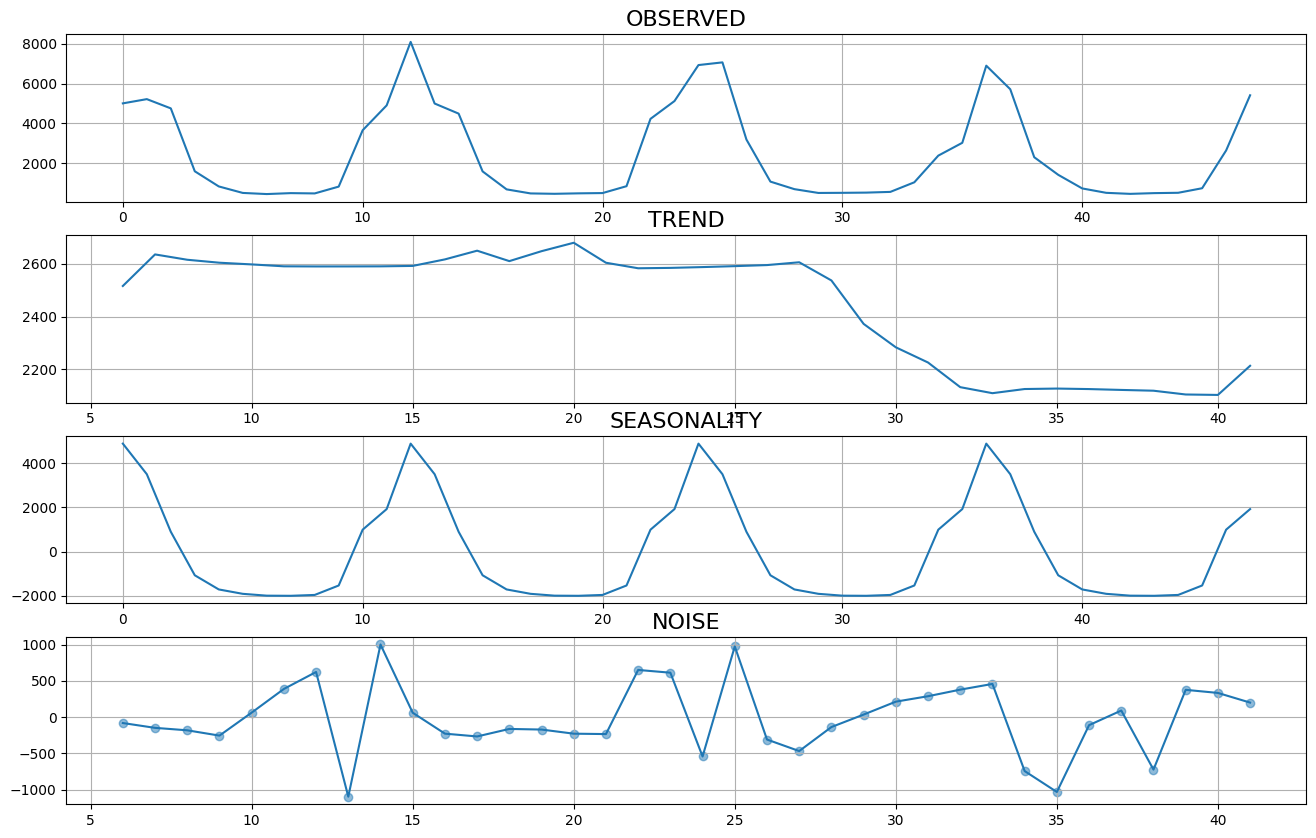

In [4]:
# Decompose Gas demand
%load_ext autoreload
from functions import decompose_ts
%autoreload 2

decompose_ts(df_demand, share_type= "gas_demand_month", samples="all", period=12)

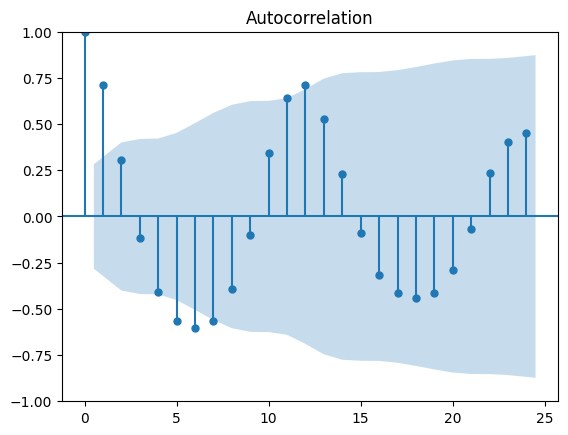

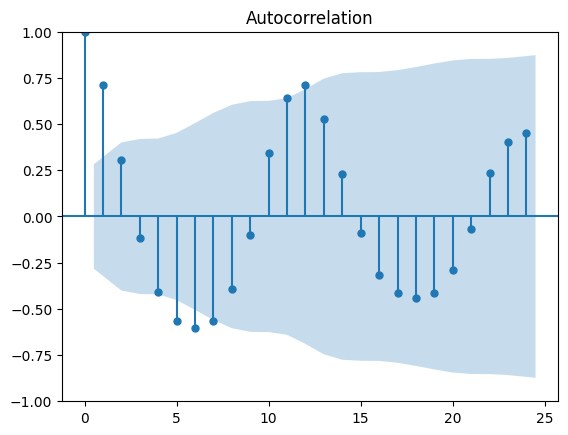

In [5]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_demand["gas_demand_month"].values, lags=24)

In [6]:
# Convert datetime from object to datetime type
df_demand['datetime'] = pd.to_datetime(df_demand['datetime'])

# Set datetime as index
df_demand = df_demand.set_index(df_demand.datetime)

# Create new column values which are day, month and year.
df_demand['month'] = df_demand["datetime"].dt.month

# Drop datetime column
df_demand.drop('datetime', axis=1, inplace=True)

In [7]:
# Find the mean, median and std of gas_demand_month based on months
monthly_stats = df_demand.groupby('month')['gas_demand_month'].agg(['mean', 'median', 'std'])

# Print the resulting statistics
print(monthly_stats)

          mean  median          std
month                              
1      6732.00  6914.5  1280.238259
2      5747.25  5464.5   928.393729
3      3678.50  3835.0  1150.225920
4      1410.00  1494.0   243.732093
5       727.50   705.0    67.391889
6       491.75   496.5    13.425722
7       461.25   451.5    27.729347
8       490.75   487.0    15.713582
9       503.75   497.0    32.887434
10      854.00   825.5   126.714903
11     3220.50  3142.0   866.806591
12     4612.25  5010.0  1082.439028


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


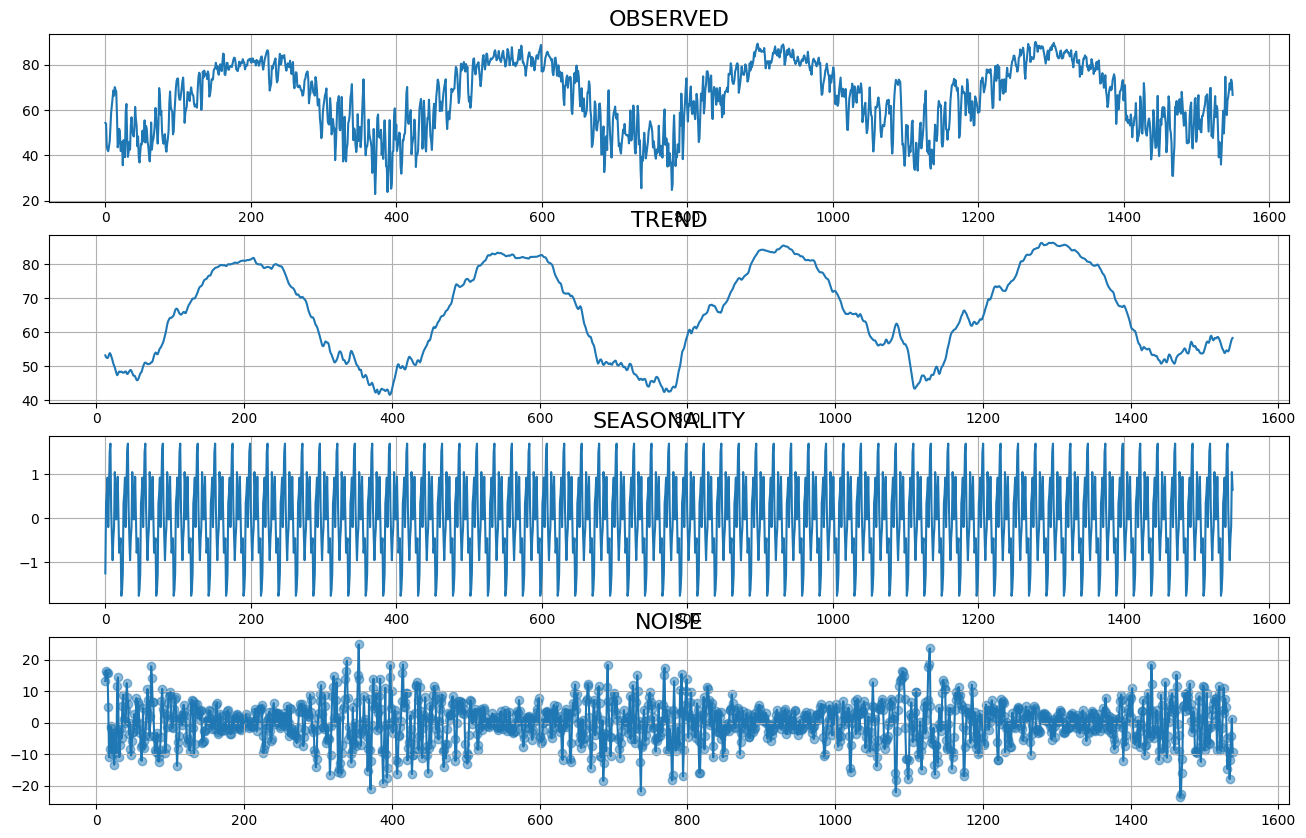

In [8]:
# Decompose temp
%load_ext autoreload
from functions import decompose_ts
%autoreload 2

decompose_ts(df_temp, share_type= "temperature_day", samples="all", period=24)

In [9]:
# Convert datetime from object to datetime type
df_temp['datetime'] = pd.to_datetime(df_temp['datetime'])

# Set datetime as index
df_temp = df_temp.set_index(df_temp.datetime)

# Create new column values which are day, month and year.
df_temp['year'] = df_temp["datetime"].dt.year
df_temp['month'] = df_temp["datetime"].dt.month
df_temp['day'] = df_temp["datetime"].dt.day

# Drop datetime column
df_temp.drop('datetime', axis=1, inplace=True)

# Cut of the dataframe at 2017-01-01 to match the demand
cut_off_date = pd.to_datetime('2017-01-01')
df_temp = df_temp[df_temp.index <= cut_off_date]

## Forecasting

### Gas Demand

#### Base model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Start date for training: 2013-01-01 00:00:00
End date for training: 2016-08-01 00:00:00
Start date for test: 2016-09-01 00:00:00
End date for test: 2016-12-01 00:00:00
The historical average is: 2419.0454545454545


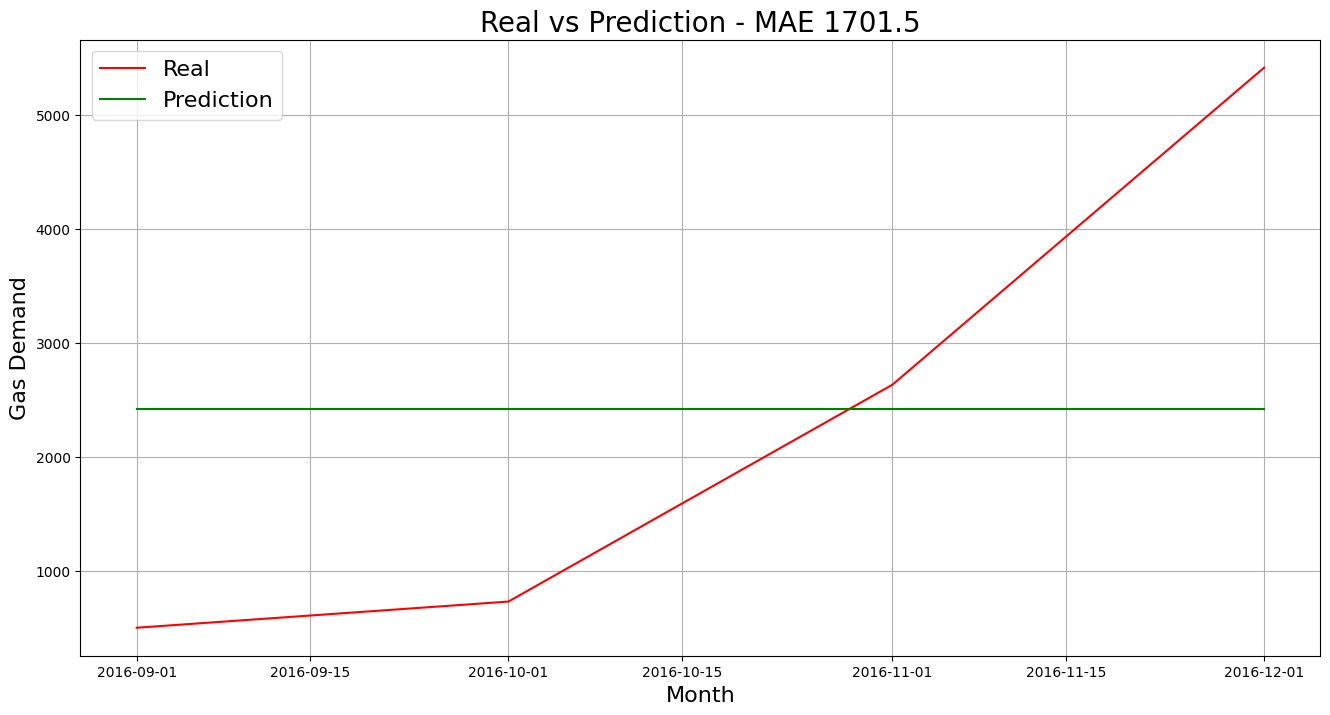

In [10]:
# Plot base model
%load_ext autoreload
from functions import train_time_series_with_avg
%autoreload 2
train_time_series_with_avg(df_demand, target_var="gas_demand_month", horizon=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Forecasting: 2410.7916666666665


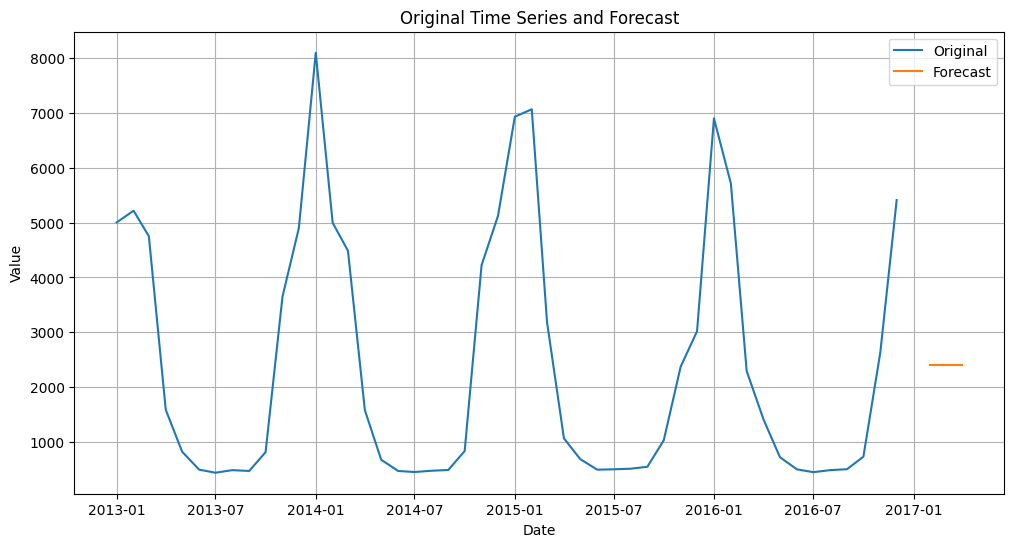

In [11]:
# Make forecast using baseline model
%load_ext autoreload
from functions import average_forecast
%autoreload 2
start_date = '2017-01-01'
end_date = '2017-04-01'
# Generate the forecast using the average method
forecast_df = average_forecast(df_demand, start_date, end_date, target="gas_demand_month")

#### Machine Learning

In [65]:
# Prepare data for machine learning
%load_ext autoreload
from functions import create_lagged_matrix
%autoreload 2

# Define the number of lagged values
lag = 7

# Create X and y arrays
X, y, lagged_df = create_lagged_matrix(df_demand, 'gas_demand_month', lag)

# Display the shapes of X and y
print('X shape:', X.shape)
print('y shape:', y.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
X shape: (41, 6)
y shape: (41,)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Predicted values for 3 months:
[[ 631.81891682]
 [1906.77560698]
 [2201.50036691]
 [2578.61395171]]


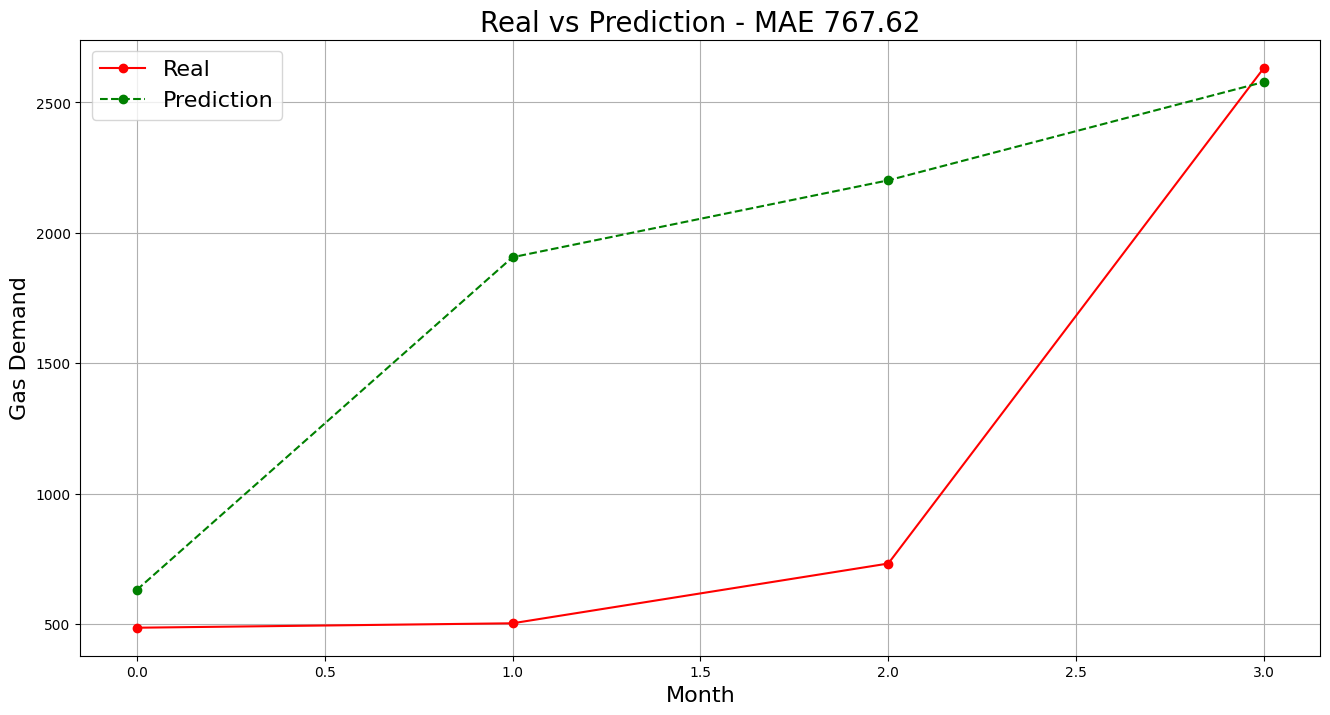

In [66]:
# Train and test on using Linear Regression
%load_ext autoreload
from functions import train_time_series_with_linreg
%autoreload 2
model, mae, df_importances = train_time_series_with_linreg(X,y,horizon=4)

In [67]:
# Train and test on using Linear Regression
%load_ext autoreload
from functions import iterative_forecasting
%autoreload 2
forecast_df = iterative_forecasting(X = X,model=model,num_forecasts=4,column_names=["lag1","lag2","lag3","lag4","lag5","lag6"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Forecast nr: 0
Predicted: [2578.61395171]
Forecast nr: 1
Predicted: [3947.68421052]
Forecast nr: 2
Predicted: [4720.88751496]
Forecast nr: 3
Predicted: [4507.70788791]


C:\Users\jg\code\templat_reg_and_class\code\functions.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_copy = X_copy.append(new_row, ignore_index=True)
C:\Users\jg\code\templat_reg_and_class\code\functions.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_copy = X_copy.append(new_row, ignore_index=True)
C:\Users\jg\code\templat_reg_and_class\code\functions.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_copy = X_copy.append(new_row, ignore_index=True)
C:\Users\jg\code\templat_reg_and_class\code\functions.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_copy = X_copy.append(new_row, ignore_index=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30'], dtype='datetime64[ns]', freq='M')
Empty DataFrame
Columns: []
Index: [2017-01-31 00:00:00, 2017-02-28 00:00:00, 2017-03-31 00:00:00, 2017-04-30 00:00:00]


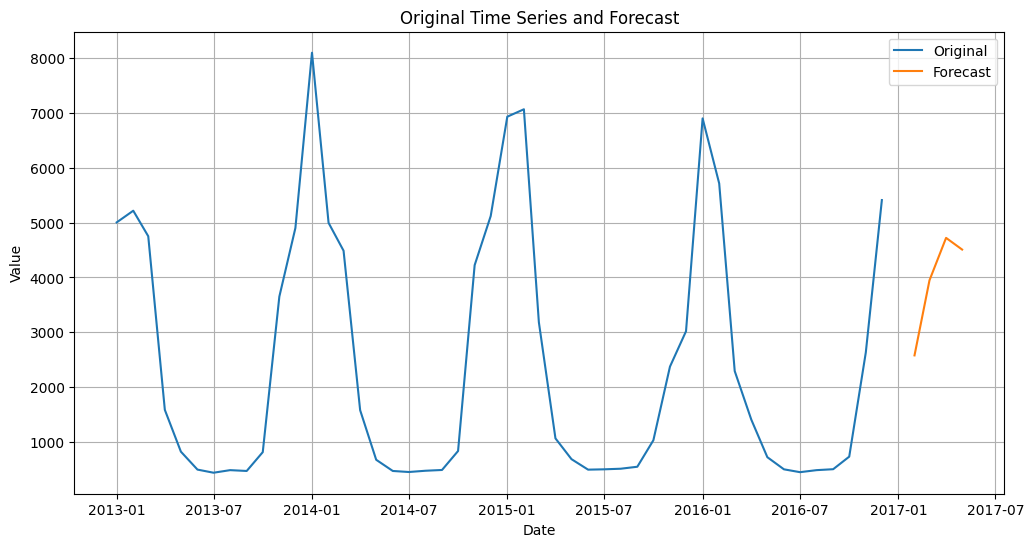

In [68]:
# Plot forecast values
%load_ext autoreload
from functions import plot_forecast
%autoreload 2
start_date = '2017-01-01'
end_date = '2017-05-01'
index = pd.date_range(start=start_date, end=end_date, freq='M')
print(index)
forecast_df = pd.DataFrame(index=index)
print(forecast_df)

forecast_values = [2578.61, 3947.68, 4720.88,4507.70]  # Example forecasted values
forecast_df['Forecast'] = forecast_values
# Generate the forecast using the average method
forecast_df = plot_forecast(df_demand,forecast_df,target='gas_demand_month')

Trying to model with different lag values. Based on forecast the model with lag_6 features seems to make most sense.